In [ ]:
%matplotlib inline

import os
import cmaps
import salem
import numpy as np
import xarray as xr
import geopandas as gpd
from pylab import rcParams
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.colors import SymLogNorm

params = {'backend': 'ps',
        'axes.labelsize': 25,
        'grid.linewidth': 0.2,
        'font.size': 25,
        'legend.fontsize': 18,
        'legend.frameon': False,
        'xtick.labelsize': 30,
        'xtick.direction': 'out',
        'ytick.labelsize': 30,
        'ytick.direction': 'out',
        'legend.handlelength': 1,
        'legend.handleheight': 1,
        'savefig.bbox': 'tight',
        'axes.unicode_minus': False,
        "mathtext.default":"regular",
        'text.usetex': False}
rcParams.update(params)

def draw_all(prefix, yr_stt, yr_end, cmap, region, level):
    def data_process(data_path, i, j, yr_stt, yr_end, region):
        image = xr.open_dataset(f'{data_path}/net_methane_{yr_stt}_{yr_end}_tmp3.nc').sel(lon=slice(region[0],region[1]),lat=slice(region[3],region[2]))
        s = image['ch4'][i+4*j,::-1,:]
        s = np.where(s<0, np.nan, s)    
        return s

    def draw(ax, s, cmap, region, level, year):
        img = ax.imshow(s, cmap=cmap,
                        extent=[region[0], region[1], region[3], region[2]],
                        vmin=level[0], vmax=level[-1])
        
        for spine in ax.spines.values():
            spine.set_edgecolor('black')  
            spine.set_linewidth(2)

        ax.set_xlim(region[0], region[1])
        ax.set_ylim(region[2], region[3])
        ax.set_title(f'{year}', fontsize=20)

        arr_x = np.arange(region[0]+60, region[1], 60)
        arr_y = np.arange(region[2], region[3], 30)
        # ax.set_yticks(arr_y)
        # ax.set_yticklabels(arr_y, fontsize=28)
        # ax.set_xlabel('Longitude', fontsize=28)
        # ax.set_xticks(arr_x)
        # ax.set_xticklabels(arr_x, fontsize=28)
        # ax.set_ylabel('Latitude', fontsize=28)
        
        ax.add_feature(cfeature.COASTLINE)
        rivers = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '110m', edgecolor='blue', facecolor='none')
        ax.add_feature(rivers)
        # ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='lightblue')

        ax.xaxis.set_major_formatter(LongitudeFormatter())
        ax.yaxis.set_major_formatter(LatitudeFormatter())

        # gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linestyle='--', color='#4E616C')   
        # gl.xlocator = ticker.FixedLocator(np.arange(-120, 181, 60)) 
        # gl.ylocator = ticker.FixedLocator(np.arange(-60, 91, 30)) 
        return img

    shp_path = '/share/home/dq076/data/Shp/'
    data_path  = f'/share/home/dq076/data/cases/ME/{prefix}/data/'
    # shp = gpd.GeoDataFrame.from_file(shp_path+'/World_CN/ne_10m_admin_0_countries_chn.shp')

    for j in range(6):
        fig = plt.figure(figsize=(16, 8), dpi=300)
        fig.subplots_adjust(left=0.02, right=0.98, bottom=0.08, top=0.98, hspace=0.1, wspace=0.06)
        gs = GridSpec(2, 2, figure=fig)
        for i, year in enumerate(range(yr_stt+4*j,yr_stt+4*(j+1))):
            ax = fig.add_subplot(gs[i//2,i%2], projection=ccrs.PlateCarree())
            s = data_process(data_path, i, j, yr_stt, yr_end, region)
            img = draw(ax, s, cmap, region, level, year)

        cbar_ax = fig.add_axes([0.05, 0.05, 0.9, 0.02], frameon=True)
        cb = fig.colorbar(img, cax=cbar_ax, orientation='horizontal', spacing='uniform')
        cb.set_ticks(level)
        cb.ax.tick_params(labelsize=20)
        plt.show()

if __name__ == '__main__':
    prefix = 'ME_g_exp1'
    yr_stt = 1995
    yr_end = 2019
    region = [-180,180,-60,90]
    level = np.linspace(0,100,6)
    cmap = cmaps.StepSeq25_r
    # cmap = cmaps.cmocean_balance
    draw_all(prefix, yr_stt, yr_end, cmap, region, level)

In [43]:
%matplotlib inline

import os
import cmaps
import numpy as np
import xarray as xr
import pandas as pd
import netCDF4 as nc
import rioxarray as rxr
import geopandas as gpd
from pylab import rcParams
# import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import matplotlib.font_manager as fm
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

pd.set_option('display.max_columns', None)

params = {'font.family': 'Arial',
          'backend': 'ps',
          'axes.labelsize': 25,
          'grid.linewidth': 0.2,
          'font.size': 25,
          'legend.fontsize': 18,
          'legend.frameon': False,
          'xtick.labelsize': 30,
          'xtick.direction': 'out',
          'ytick.labelsize': 30,
          'ytick.direction': 'out',
          'legend.handlelength': 1,
          'legend.handleheight': 1,
          'savefig.bbox': 'tight',
          'axes.unicode_minus': False,
          "mathtext.default":"regular",
          'text.usetex': False}
rcParams.update(params)

def define_colormap(levels, cmap):
    """Define custom colormap and normalization."""
    # Generate colormap
    cmap = plt.get_cmap(cmap)
    color = cmap(np.linspace(0, 1, len(levels) - 1))
    cmap_custom = colors.ListedColormap(color)
    cmap_custom.set_under(cmap(0))
    cmap_custom.set_over(color[-1])
    norm = colors.BoundaryNorm(levels, cmap_custom.N)
    return cmap_custom, norm

def draw(prefix,name,level,cmap,extent,norm):
    ds = xr.open_dataset(f'/share/home/dq076/data/cases/ME/{prefix}/data/net_methane_1995_2020_tmp3.nc').sel(lon=slice(extent[0], extent[1]), lat=slice(extent[3], extent[2]))
    data = ds['ch4'][-1,:,:]
    print(data)
    # data = np.ma.masked_where(np.isnan(data), data)
    # data = np.flipud(data)
    
    fig = plt.figure(figsize=(12, 6), dpi=300)

    fig.subplots_adjust(left=0.05, right=0.98, 
                    bottom=0.14, top=0.95, hspace=0.25) 
        
    #Create a subgraph grid with 2 rows and 3 columns
    gs = GridSpec(2, 6)
    ax = fig.add_subplot(gs[:, :], projection=ccrs.PlateCarree())

    # Set drawing mode(note:extent's lat from positive to negative)
    img = ax.imshow(data, cmap=cmap, extent=extent, norm=norm)

    for spine in ax.spines.values():
        spine.set_edgecolor('black')  
        spine.set_linewidth(0)  

    ax.set_xlim(region[0], region[1])
    ax.set_ylim(region[2], region[3])

    # coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '50m', edgecolor='0.6', facecolor='none')
    rivers = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '110m', edgecolor='0.6', facecolor='none')
    ax.add_feature(cfeature.LAND, facecolor='0.95')
    # ax.add_feature(coastline, linewidth=0.6)
    ax.add_feature(cfeature.LAKES, alpha=1, facecolor='white', edgecolor='white')
    ax.add_feature(rivers, linewidth=0.8)
    # ax.gridlines(draw_labels=False, linestyle=':', linewidth=0.7, color='grey', alpha=0.8)

    ax.add_feature(cfeature.COASTLINE)
    ax.set_extent(region)
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())

    # ax.grid(ls = "--", lw = 0.25, color = "#4E616C")

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linestyle='--', color='#4E616C')   
    gl.xlocator = ticker.FixedLocator(np.arange(-120, 181, 60)) 
    gl.ylocator = ticker.FixedLocator(np.arange(-60, 91, 30))    

    # From the bottom left corner x, y, width, height
    custom_ticks = [0, 10, 20, 30, 40]
    # cbar_ax = fig.add_axes([0.4, 0.14, 0.4, 0.03], frameon = False) 
    cbar_ax = fig.add_axes([0.1, 0.06, 0.8, 0.04], frameon = True) 
    cb = fig.colorbar(img, 
                    drawedges=True,
                    ticks=level, 
                    cax=cbar_ax, 
                    orientation='horizontal',
                    spacing='uniform')

    cb.ax.tick_params(labelsize=20)
    cb.ax.yaxis.set_tick_params(direction='out', width=1.5)
    # for label in cb.ax.get_xticklabels() + cb.ax.get_yticklabels():
    #     label.set_fontproperties(font_properties)
    cb.set_label(f'{name[3]}', fontsize=30, fontweight='bold')

    cb.outline.set_visible(True)
    cb.outline.set_edgecolor('#333333')
    cb.outline.set_linewidth(2)

    plt.tight_layout()
    plt.show()

<xarray.DataArray 'ch4' (lat: 75, lon: 180)> Size: 54kB
[13500 values with dtype=float32]
Coordinates:
    time     datetime64[ns] 8B 2020-07-02
  * lon      (lon) float32 720B -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
  * lat      (lat) float32 300B 89.0 87.0 85.0 83.0 ... -53.0 -55.0 -57.0 -59.0
Attributes:
    units:         mgCH4/m2/d
    cell_methods:  time: mean


/tmp/ipykernel_120324/2701347393.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findf

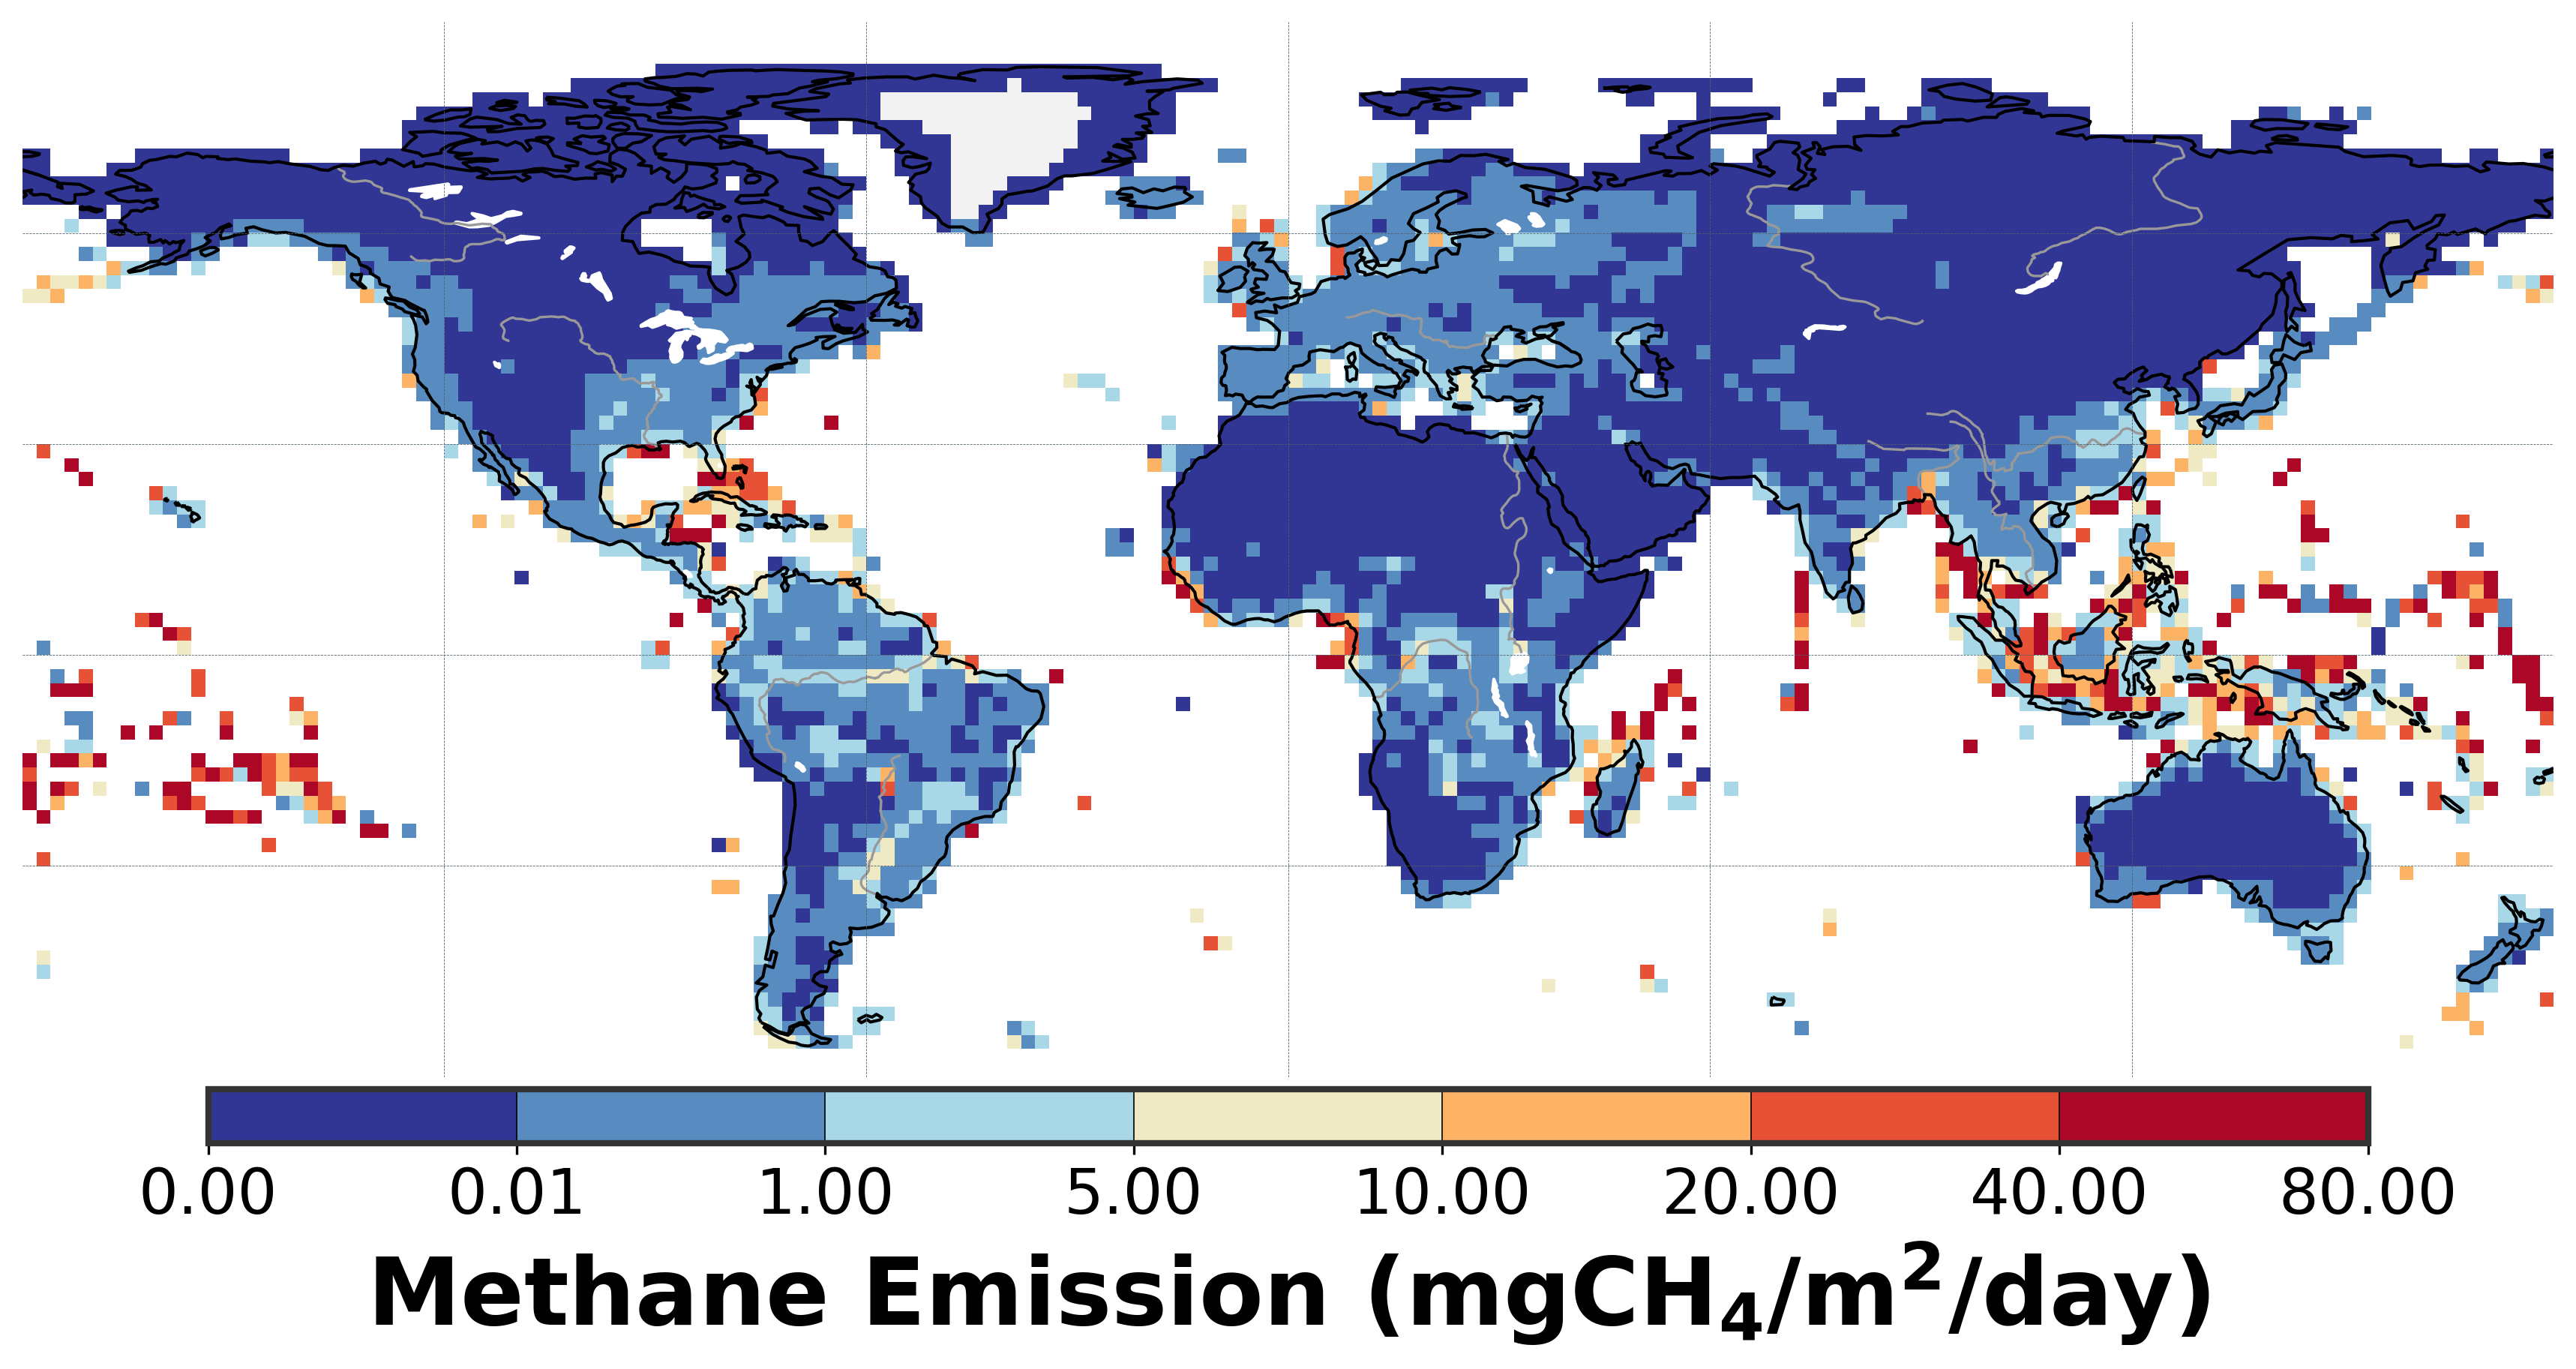

In [45]:
prefix='ME_g_exp1'
region = [-180,180,-60,90]
name = [f'Sbedrock', 'Sbedrock', 'Sbedrock', 'Methane Emission (mg$CH_{4}$/$m^{2}$/day)']
level = [0, 0.01, 1, 5, 10, 20, 40, 80]
cmap = cmaps.cmp_b2r

cmap, norm = define_colormap(level, cmap)
draw(prefix,name,level,cmap,region,norm)